# Wind Impact on LSTM Agent Performance

How robust is the RL architecture trained with wind estimations (from an LSTM) all wind?

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from tqdm import tqdm

from environments import OctorotorEnvSelector
from systems.pid_agent import PIDAgent
from multirotor.helpers import DataLog
from stable_baselines3 import PPO
from parameters import pid_params
from trajectories import nasa_wp

In [2]:
# study, best_agent, best_params = get_agent('windlstm')

# best_params['bounding_rect_length']=200
# best_params['steps_u']=50

In [3]:
best_agent = PPO.load('./saved_models/lower_pid/37') 
# best_agent = PPO.load('./saved_models/bad_pid/27') 


In [4]:
pid_parameters = pid_params()
# pos_mult = 0.2
# vel_mult = 0.2
# pid_parameters = pid_params(
#     pos_p=[pos_mult*0.3, pos_mult*0.3, 0.2],
#     vel_p=[vel_mult*1, vel_mult*1, 100],
#     vel_i=[vel_mult*0.1, vel_mult*0.1, 0]
# )

In [5]:
best_params = {'steps_u':50, 'scaling_factor':5, 'window_distance':23, 'pid_parameters':pid_parameters}

In [6]:
env_selector = OctorotorEnvSelector()
square_wpts = np.array([[100,0,30], [100,100,30], [0,100,30], [0,0,30]])

In [7]:
def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y:np.ndarray, z:np.ndarray) -> np.ndarray:
        """
        Calculates the trajectory tracking error. 
        The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

        Parameters
        ----------
        initial_pos : tuple  
            the initial position of the UAV.
        waypoints : np.ndarray 
            the reference positions at each point in time.
        x : np.ndarray 
            the x positions of the UAV.
        y : np.ndarray 
            the y positions of the UAV.
        z : np.ndarray
            the z positions of the UAV.

        Returns
        -------
        np.ndarray 
            the trajectory tracking error at each point in time.
        """
        ttes = []
        prev = initial_pos
        for i, waypoint in enumerate(waypoints):
            if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
                prev = waypoints[i-1]

            v1 = waypoint - prev
            v2 = np.array([x[i],y[i],z[i]]) - prev
            tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
            ttes.append(tte)
                
        return np.array(ttes)

In [8]:
import numpy as np

def get_tte(initial_pos: tuple, waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray) -> np.ndarray:
    """
    Calculates the trajectory tracking error.
    The distance between the current point and the vector between previous and next wp. Uses ||v1 x v2|| / ||v1||.

    Parameters
    ----------
    initial_pos : tuple
        the initial position of the UAV.
    waypoints : np.ndarray
        the reference positions at each point in time.
    x : np.ndarray
        the x positions of the UAV.
    y : np.ndarray
        the y positions of the UAV.
    z : np.ndarray
        the z positions of the UAV.

    Returns
    -------
    np.ndarray
        the trajectory tracking error at each point in time.
    """
    ttes = []
    prev = initial_pos
    for i, waypoint in enumerate(waypoints):
        if i > 0 and not np.array_equal(waypoints[i-1], waypoints[i]):
            prev = waypoints[i-1]

        next_wp = waypoints[i]
        v1 = next_wp - prev
        v2 = np.array([x[i], y[i], z[i]]) - prev
        tte = np.linalg.norm(np.cross(v1, v2)) / (np.linalg.norm(v1) + 1e-6)
        ttes.append(tte)

    return np.array(ttes)


In [9]:
def toc(tte: np.ndarray):
    corridor = 5
    return best_params['steps_u'] * len(tte[tte > corridor]) / 100

In [10]:
def completed_mission(waypoints: np.ndarray, x: np.ndarray, y: np.ndarray, z: np.ndarray, radius: float = 0.65):
        for waypoint in waypoints:
            reached_waypoint = False

            for position in zip(x,y,z):
                dist = np.linalg.norm(waypoint - position)

                if dist <= radius:
                    reached_waypoint = True
                    break

            if not reached_waypoint:
                return False
            
        return True

In [11]:
def run_trajectory(env_selector, wind_ranges: np.ndarray, agent, params):
    env = env_selector.get_env("lstm", params, wind_ranges, square_wpts, start_alt=30, has_turbulence=True)
    env.wp_options = [square_wpts]
    done = False
    state = np.array(env.reset(), dtype=np.float32)
    log = DataLog(env.base_env.vehicle, 
                      other_vars=('reward','next_wp', 'disturbance_pred', 'disturbance', 'lstm_input', 'agent_actions', 'observations'))
    inputs = []
    while not done:
        action = agent.predict(state, deterministic=True)[0]
        # if env.base_env.vehicle.position[1] > 20:
        #     action = [-0.1,0,0]
        # else:
        action = [0, 0, 0]
        state, reward, done, info = env.step(action)
        state = np.array(state, dtype=np.float32)
        log.log(reward=reward, next_wp=env.base_env.next_waypt, disturbance_pred=env.base_env.disturbance_pred, 
                disturbance=env.base_env.disturbance, lstm_input=env.base_env.lstm_input, agent_actions=action,
                observations=env.base_env.observed_state)
        inputs.append(np.array(env.base_env.lstm_input))
        

    log.done_logging()
    return log, info, np.array(inputs)

In [12]:
log, info, inputs = run_trajectory(env_selector, [(12,12), (0,0), (0,0)], best_agent, best_params)

In [13]:
square_wpts[0]

array([100,   0,  30])

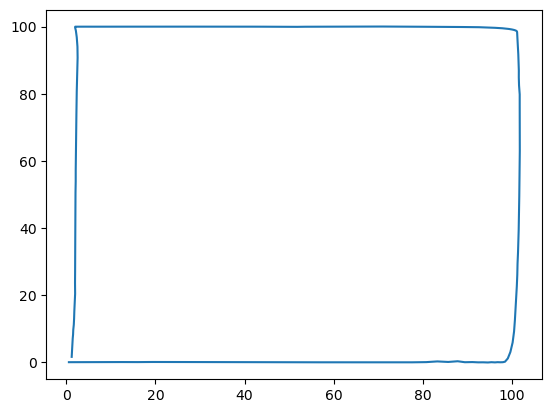

In [14]:
plt.plot(log.x, log.y)

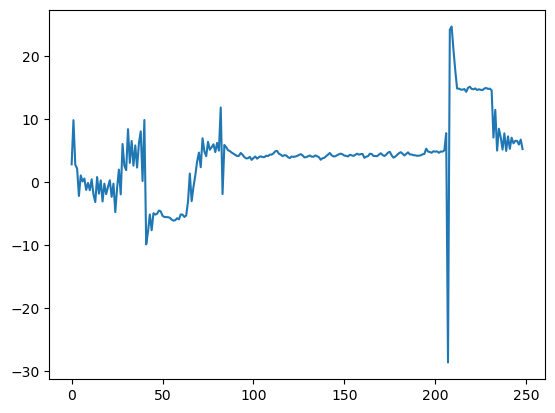

In [15]:
plt.plot(log.observations[:,16])

In [16]:
log.observations.shape

(249, 17)

In [17]:
# def save_video_data(log, tte):
#     X = log.x
#     Y = log.y
#     Z = log.z
    
#     roll = log.roll
#     pitch = log.pitch
#     yaw = log.yaw
    
#     wp_x = log.next_wp[:,0]
#     wp_y = log.next_wp[:,1]
#     wp_z = log.next_wp[:,2]
    
#     data_array = np.vstack([X, Y, Z, roll, pitch, yaw, wp_x, wp_y, wp_z, tte]).T
#     df = pd.DataFrame(data_array, columns=[['X', 'Y', 'Z', 'Roll', 'Pitch', 'Yaw', 'WPX', 'WPY', 'WPZ', 'TTE']])
#     df.to_csv('./data/sample_data.csv')

In [18]:
# (get_tte(log.next_wp[0], log.next_wp, log.x, log.y, log.z) <= 2).astype(int)

In [19]:
# save_video_data(log, tte=get_tte(log.next_wp[0], log.next_wp, log.x, log.y, log.z))

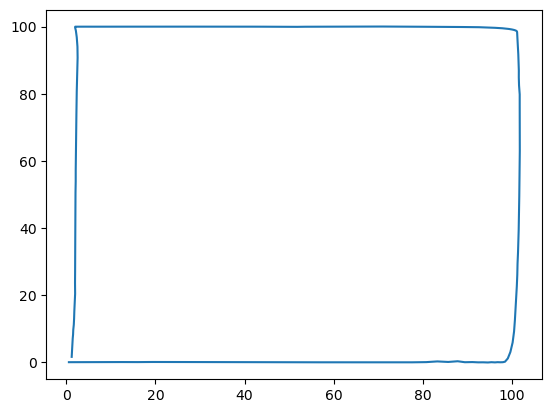

In [20]:
plt.plot(log.x, log.y)

Text(0.5, 1.0, 'RL Wind Rejection')

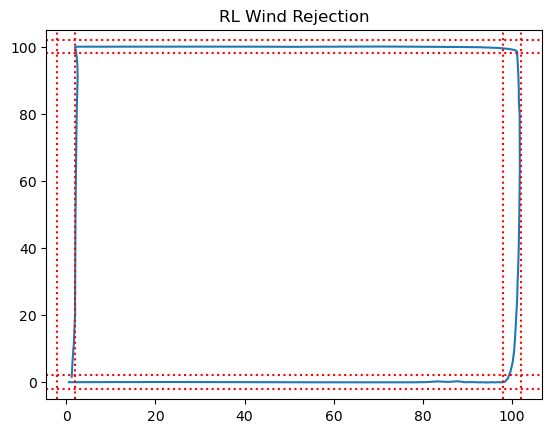

In [21]:
plt.plot(log.x, log.y)

plt.axvline(x=98, ymin=0, ymax=100, linestyle=':', color='red')
plt.axvline(x=102, ymin=0, ymax=100, linestyle=':', color='red')
plt.axvline(x=-2, ymin=0, ymax=100, linestyle=':', color='red')
plt.axvline(x=2, ymin=0, ymax=100, linestyle=':', color='red')

plt.axhline(y=98, xmin=0, xmax=100, linestyle=':', color='red')
plt.axhline(y=102, xmin=0, xmax=100, linestyle=':', color='red')
plt.axhline(y=-2, xmin=0, xmax=100, linestyle=':', color='red')
plt.axhline(y=2, xmin=0, xmax=100, linestyle=':', color='red')
plt.title("RL Wind Rejection")

Text(0, 0.5, 'Change in Velocity (m/s)')

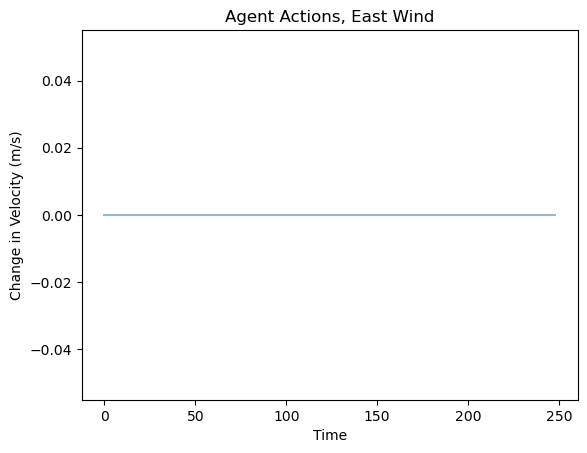

In [22]:
plt.plot(log.agent_actions[:,0], alpha=0.5)
plt.title("Agent Actions, East Wind")
plt.xlabel("Time")
plt.ylabel("Change in Velocity (m/s)")

In [23]:
toc(get_tte([0,0,30], log.next_wp, log.x, log.y, log.z))

0.0

In [24]:
np.mean(get_tte([0,0,30], log.next_wp, log.x, log.y, log.z))

0.6634038944961812

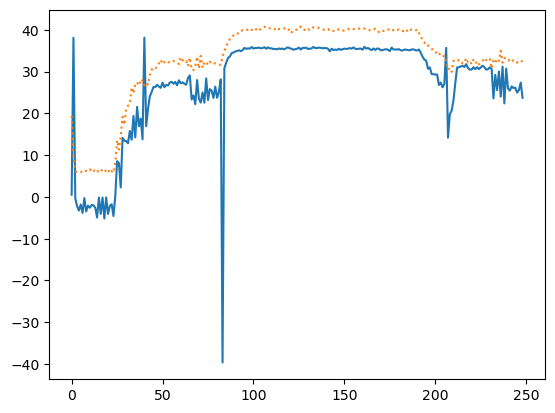

In [25]:
plt.plot(log.disturbance_pred[:,0])
plt.plot(log.disturbance[:,0], linestyle=':')

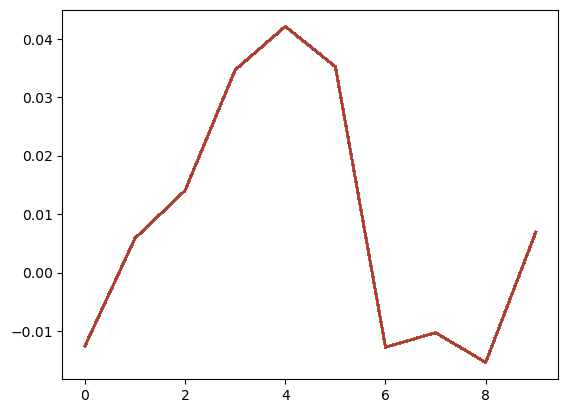

In [34]:
for i in range(len(log)):
    plt.plot(log.lstm_input[i,:,8])

In [ ]:
wind_range_dict = {
    # 'zero': [(0,0), (0,0), (0,0)],
    'n5': [(0,0), (5,5), (0,0)],
    # 'n7': [(0,0), (7,7), (0,0)],
    # 'n10': [(0,0), (10,10), (0,0)],
    # 's5': [(0,0), (-5,-5), (0,0)],
    # 's7': [(0,0), (-7,-7), (0,0)],
    # 's10': [(0,0), (-10,-10), (0,0)],
    # 'e5': [(5,5), (0,0), (0,0)],
    # 'e7': [(7,7), (0,0), (0,0)],
    # 'e10': [(10,10), (0,0), (0,0)],
    # 'w5': [(-5,-5), (0,0), (0,0)],
    # 'w7': [(-7,-7), (0,0), (0,0)],
    # 'w10': [(-10,-10), (0,0), (0,0)],
    # 'nw5': [(-3.53553391,-3.53553391), (3.53553391,3.53553391), (0,0)],
    # 'nw7': [(-4.94974747,-4.94974747), (4.94974747,4.94974747), (0,0)],
    # 'nw10': [(-7.07106781,-7.07106781), (7.07106781,7.07106781), (0,0)],
    # 'sw5': [(-3.53553391,-3.53553391), (-3.53553391,-3.53553391), (0,0)],
    # 'sw7': [(-4.94974747,-4.94974747), (-4.94974747,-4.94974747), (0,0)],
    # 'sw10': [(-7.07106781,-7.07106781), (-7.07106781,-7.07106781), (0,0)],
    # 'ne5': [(3.53553391,3.53553391), (3.53553391,3.53553391), (0,0)],
    # 'ne7': [(4.94974747,4.94974747), (4.94974747,4.94974747), (0,0)],
    # 'ne10': [(7.07106781,7.07106781), (7.07106781,7.07106781), (0,0)],
    # 'se5': [(3.53553391,3.53553391), (-3.53553391,-3.53553391), (0,0)],
    # 'se7': [(4.94974747,4.94974747), (-4.94974747,-4.94974747), (0,0)],
    # 'se10': [(7.07106781,7.07106781), (-7.07106781,-7.07106781), (0,0)],
}

In [ ]:
wind_results = pd.DataFrame(columns=['Wind', 'Total TTE', 'Mean TTE', 'Completed Mission', 'Reward', 'Time Outside Corridor'])

In [ ]:
def run_wind_sweep(results, wind_dict, agent, params):
    for wind in tqdm(wind_dict.keys()):
        log, info = run_trajectory(env_selector, wind_dict[wind], agent, params)
        print(info)
        traj_err = get_tte(np.array([0,0,30]), log.next_wp, log.x, log.y, log.z)
        new_result = {
            'Wind': wind,
            'Mean TTE': np.mean(traj_err),
            'Total TTE': np.sum(traj_err),
            'Completed Mission': completed_mission(square_wpts, log.x, log.y, log.z, radius=5),
            'Reward': np.sum(log.reward),
            'Time Outside Corridor': toc(traj_err)
        }
        results = pd.concat([results, pd.DataFrame([new_result])], ignore_index=True)

    return results, log

In [ ]:
wind_results, log = run_wind_sweep(wind_results, wind_range_dict, best_agent, best_params)

  0%|          | 0/1 [00:09<?, ?it/s]


ValueError: too many values to unpack (expected 2)

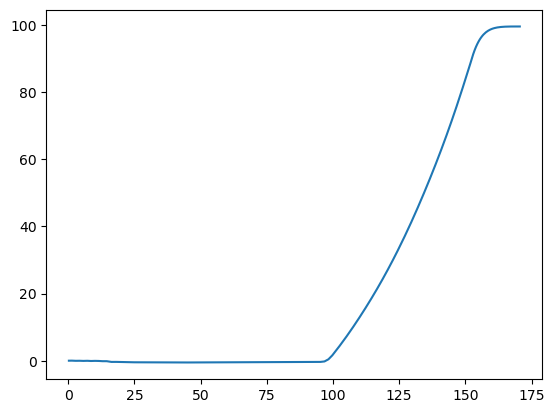

In [ ]:
plt.plot(log.x, log.y)

In [ ]:
info

NameError: name 'info' is not defined

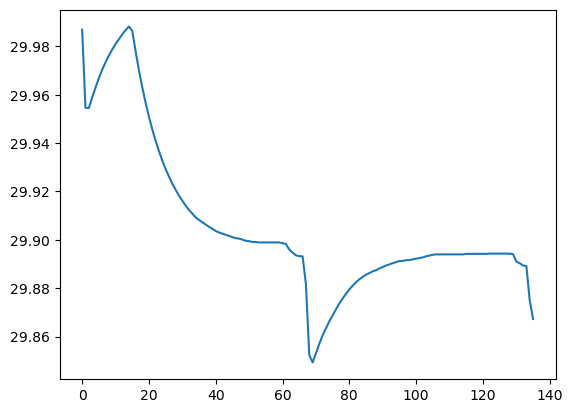

In [ ]:
plt.plot(log.z)

In [ ]:
wind_results.to_csv('./data/lstm_wind.csv')

In [ ]:
wind_results = pd.read_csv('./data/lstm_wind.csv') 

In [ ]:
wind_results

,Unnamed: 0,Wind,Total TTE,Mean TTE,Completed Mission,Reward,Time Outside Corridor
0,0,zero,124.909102,1.086166,True,8840.5270,0.0
1,1,n5,142.149895,1.204660,True,8667.4940,0.0
2,2,n7,155.779091,1.287431,True,8533.5880,0.0
3,3,n10,221.322356,1.569662,True,7874.4116,0.0
4,4,s5,124.892180,1.076657,True,8829.8370,0.0
5,5,s7,130.677418,1.088978,True,8772.7210,0.0
6,6,s10,186.643402,1.323712,True,8208.4810,0.0
7,7,e5,133.603782,1.151757,True,8743.3950,0.0
8,8,e7,134.131805,1.108527,True,8744.3940,0.0
9,9,e10,182.265084,1.320761,True,8257.2350,0.0


In [ ]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Reward'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Reward'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Reward'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Reward'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Reward'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Reward'].std())

Mean reward for 5 m/s:  8736.357
Std reward for 5 m/s:  81.24075
Mean reward for 7 m/s:  8636.789
Std reward for 7 m/s:  113.17812
Mean reward for 10 m/s:  8085.25
Std reward for 10 m/s:  241.5662


In [ ]:
print("Mean for 0 m/s: ", wind_results[wind_results['Wind'].str.contains("zero")]['Mean TTE'].mean())
print("Mean for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Mean TTE'].mean())
print("Std for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Mean TTE'].std())
print("Mean for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Mean TTE'].mean())
print("Std for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Mean TTE'].std())
print("Mean for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Mean TTE'].mean())
print("Std for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Mean TTE'].std())

Mean for 0 m/s:  nan
Mean for 5 m/s:  nan
Std for 5 m/s:  nan
Mean for 7 m/s:  nan
Std for 7 m/s:  nan
Mean for 10 m/s:  nan
Std for 10 m/s:  nan


In [ ]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Time Outside Corridor'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Time Outside Corridor'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Time Outside Corridor'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Time Outside Corridor'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Time Outside Corridor'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Time Outside Corridor'].std())

Mean reward for 5 m/s:  0.0
Std reward for 5 m/s:  0.0
Mean reward for 7 m/s:  0.0
Std reward for 7 m/s:  0.0
Mean reward for 10 m/s:  0.0
Std reward for 10 m/s:  0.0


In [ ]:
print("Mean reward for 5 m/s: ", wind_results[wind_results['Wind'].str.contains("5")]['Completed Mission'].mean())
print("Std reward for 5 m/s: ",wind_results[wind_results['Wind'].str.contains("5")]['Completed Mission'].std())
print("Mean reward for 7 m/s: ", wind_results[wind_results['Wind'].str.contains("7")]['Completed Mission'].mean())
print("Std reward for 7 m/s: ",wind_results[wind_results['Wind'].str.contains("7")]['Completed Mission'].std())
print("Mean reward for 10 m/s: ", wind_results[wind_results['Wind'].str.contains("10")]['Completed Mission'].mean())
print("Std reward for 10 m/s: ",wind_results[wind_results['Wind'].str.contains("10")]['Completed Mission'].std())

Mean reward for 5 m/s:  1.0
Std reward for 5 m/s:  0.0
Mean reward for 7 m/s:  1.0
Std reward for 7 m/s:  0.0
Mean reward for 10 m/s:  1.0
Std reward for 10 m/s:  0.0
